In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/braincancer/data
/kaggle/input/brain-cancer-detection-mri-images/Dataset/tumor/tumor (243).jpg
/kaggle/input/brain-cancer-detection-mri-images/Dataset/tumor/tumor (281).jpg
/kaggle/input/brain-cancer-detection-mri-images/Dataset/tumor/tumor (237).jpg
/kaggle/input/brain-cancer-detection-mri-images/Dataset/tumor/tumor (202).jpg
/kaggle/input/brain-cancer-detection-mri-images/Dataset/tumor/tumor (165).jpg
/kaggle/input/brain-cancer-detection-mri-images/Dataset/tumor/tumor (77).jpg
/kaggle/input/brain-cancer-detection-mri-images/Dataset/tumor/tumor (28).jpg
/kaggle/input/brain-cancer-detection-mri-images/Dataset/tumor/tumor (193).jpg
/kaggle/input/brain-cancer-detection-mri-images/Dataset/tumor/tumor (275).jpg
/kaggle/input/brain-cancer-detection-mri-images/Dataset/tumor/tumor (116).jpg
/kaggle/input/brain-cancer-detection-mri-images/Dataset/tumor/tumor (187).jpg
/kaggle/input/brain-cancer-detection-mri-images/Dataset/tumor/tumor (302).jpg
/kaggle/input/brain-cancer-detectio

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D
import os
from sklearn.metrics import confusion_matrix,classification_report 
import random

# Preprocessing

In [3]:
# Set up the path for your dataset
dataset_path = "/kaggle/input/brain-cancer-detection-mri-images/Dataset"
healthy_path = os.path.join(dataset_path, 'healthy')
tumor_path = os.path.join(dataset_path, 'tumor')

# Constants
img_size = 128 
input_shape = (img_size, img_size, 3)

# Helper functions for loading and preprocessing the dataset
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = tf.keras.preprocessing.image.load_img(os.path.join(folder, filename), target_size=(img_size, img_size))
        if img is not None:
            images.append(tf.keras.preprocessing.image.img_to_array(img))
    return images

# Load images for healthy and tumor categories
healthy_images = load_images_from_folder(healthy_path)
tumor_images = load_images_from_folder(tumor_path)

# Labels for the dataset
healthy_labels = [0] * len(healthy_images)
tumor_labels = [1] * len(tumor_images)

# Combine and reshape
X = np.array(healthy_images + tumor_images)
y = np.array(healthy_labels + tumor_labels)
X = X / 255.0

# Visualization

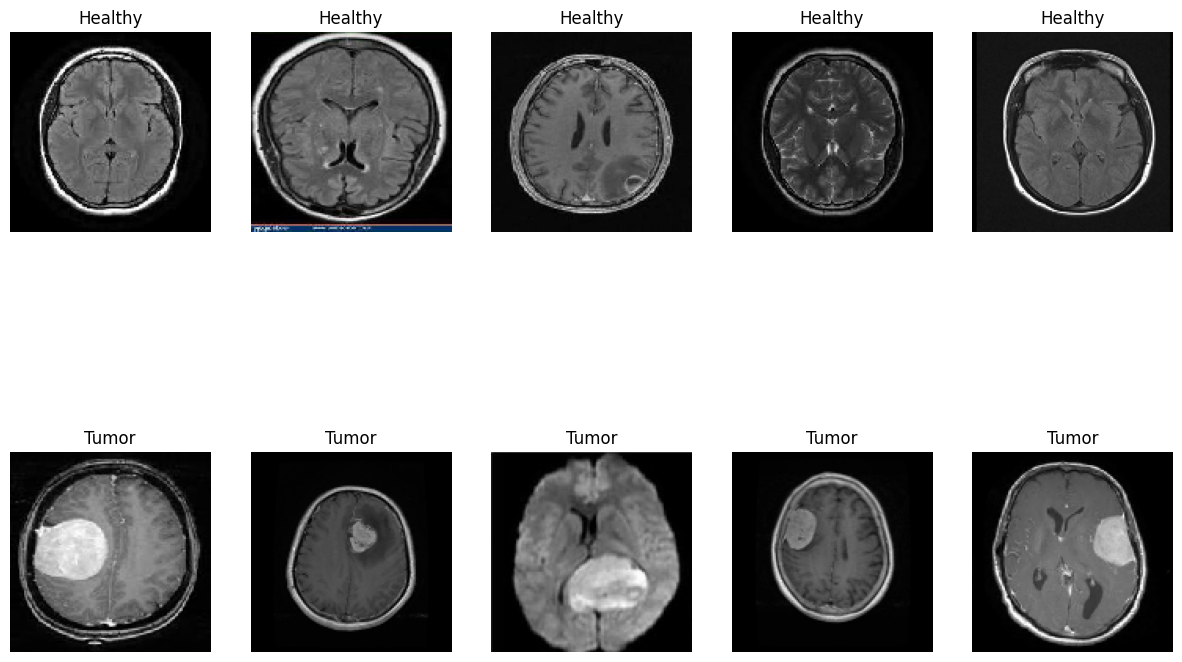

In [4]:
# Visualize a few sample images from the dataset, showing both healthy and tumor images
def show_sample_images(X, y, num_samples=10):
    plt.figure(figsize=(15, 10))
    healthy_count = 0
    tumor_count = 0
    for i in range(num_samples):
        plt.subplot(2, num_samples // 2, i + 1)
        if healthy_count < num_samples // 2:
            plt.imshow(X[healthy_count])
            plt.title('Healthy', fontsize=12)
            healthy_count += 1
        else:
            plt.imshow(X[len(healthy_images) + tumor_count])
            plt.title('Tumor', fontsize=12)
            tumor_count += 1
        plt.axis('off')
    plt.show()

# Show sample images of both healthy and tumor
show_sample_images(X, y)

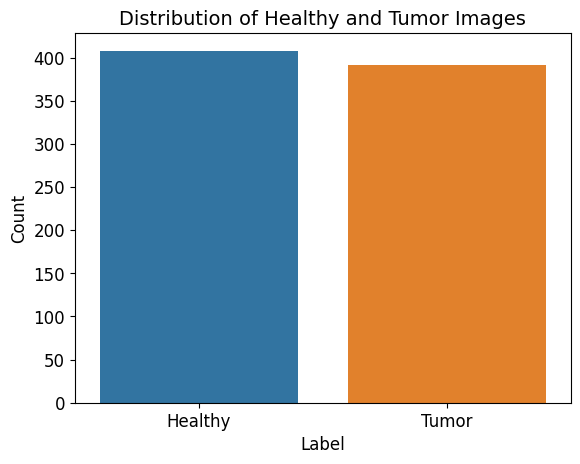

In [5]:
sns.countplot(x=y)
plt.title('Distribution of Healthy and Tumor Images', fontsize=14)
plt.xticks([0, 1], ['Healthy', 'Tumor'], fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# Data Augmentation

In [6]:
# Normalize the images

X, y = shuffle(X, y, random_state=42)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=16,shuffle=True)

# Model Preperation and Training

# Using ResNet with normal and Augmented Data

In [7]:
input_shape = (128, 128, 3)
metrics={}

In [8]:
resnet_model=Sequential()

pretrained_model=tf.keras.applications.ResNet50(include_top=False,
                                              input_shape=input_shape,
                                              pooling='max',classes=2,
                                              weights='imagenet')
for layer in pretrained_model.layers:
    layers.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(layers.Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(layers.Dropout(0.5))
resnet_model.add(Dense(1,activation='sigmoid'))
resnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [9]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
loss='binary_crossentropy',
metrics=['accuracy'])

In [10]:
resnet_model_aug=Sequential()

pretrained_model=tf.keras.applications.ResNet50(include_top=False,
                                              input_shape=input_shape,
                                              pooling='max',classes=2,
                                              weights='imagenet')
for layer in pretrained_model.layers:
    layers.trainable=False

resnet_model_aug.add(pretrained_model)
resnet_model_aug.add(layers.Flatten())
resnet_model_aug.add(Dense(512, activation='relu'))
resnet_model_aug.add(layers.Dropout(0.5))
resnet_model_aug.add(Dense(1,activation='sigmoid'))
resnet_model_aug.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [11]:
resnet_model_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
loss='binary_crossentropy',
metrics=['accuracy'])

In [12]:
metrics['resnet_history']=resnet_model.fit(X_train,y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10


I0000 00:00:1732533172.244676      74 service.cc:145] XLA service 0x795af40046d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732533172.244735      74 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732533172.244741      74 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732533196.337578      74 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_36', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1732533196.380020      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 57s 274ms/step - accuracy: 0.6093 - loss: 1.7785 - val_accuracy: 0.4875 - val_loss: 0.7715
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.8101 - loss: 0.7579 - val_accuracy: 0.4875 - val_loss: 1.1559
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.8719 - loss: 0.5804 - val_accuracy: 0.4875 - val_loss: 1.5498
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.8965 - loss: 0.4105 - val_accuracy: 0.4875 - val_loss: 1.7385
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9450 - loss: 0.1583 - val_accuracy: 0.4875 - val_loss: 1.5905
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9436 - loss: 0.3041 - val_accuracy: 0.4875 - val_loss: 1.4066
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9751 - loss: 0.1261 - val_accuracy: 0.4875 - val_loss: 1.2601
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9624 - loss: 0.1258 - val_accuracy: 0.4875 - val

In [13]:
metrics['resnet_aug_history'] = resnet_model_aug.fit(train_generator, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 58s 148ms/step - accuracy: 0.6340 - loss: 1.6841 - val_accuracy: 0.4875 - val_loss: 0.8411
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.7231 - loss: 1.2049 - val_accuracy: 0.4875 - val_loss: 1.1959
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.7733 - loss: 1.0227 - val_accuracy: 0.4875 - val_loss: 0.9292
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.8363 - loss: 0.7252 - val_accuracy: 0.5000 - val_loss: 0.8957
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.8484 - loss: 0.5597 - val_accuracy: 0.5375 - val_loss: 0.8377
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.8653 - loss: 0.4430 - val_accuracy: 0.5250 - val_loss: 0.9235
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.8593 - loss: 0.5073 - val_accuracy: 0.4500 - val_loss: 0.9498
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.9038 - loss: 0.3655 - val_accuracy: 0.4437 - val_loss: 

# Using Conv2D using normal and Augmented Data

In [14]:
cnn_model=Sequential()
cnn_model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(layers.Flatten())
cnn_model.add(Dense(128,activation='relu'))
cnn_model.add(Dense(1,activation='sigmoid'))
cnn_model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
 cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [16]:
cnn_model_aug=Sequential()
cnn_model_aug.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape))
cnn_model_aug.add(MaxPooling2D(pool_size=(2,2)))
cnn_model_aug.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
cnn_model_aug.add(MaxPooling2D(pool_size=(2,2)))
cnn_model_aug.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
cnn_model_aug.add(MaxPooling2D(pool_size=(2,2)))
cnn_model_aug.add(layers.Flatten())
cnn_model_aug.add(Dense(128,activation='relu'))
cnn_model_aug.add(Dense(1,activation='sigmoid'))
cnn_model_aug.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
 cnn_model_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [18]:
metrics['cnn_history'] = cnn_model.fit(X_train,y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.5981 - loss: 0.6786 - val_accuracy: 0.7375 - val_loss: 0.6298
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7706 - loss: 0.6311 - val_accuracy: 0.8125 - val_loss: 0.5823
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8013 - loss: 0.5899 - val_accuracy: 0.8250 - val_loss: 0.5381
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8077 - loss: 0.5480 - val_accuracy: 0.8500 - val_loss: 0.5006
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8230 - loss: 0.5105 - val_accuracy: 0.8687 - val_loss: 0.4690
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8238 - loss: 0.4901 - val_accuracy: 0.8750 - val_loss: 0.4419
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8507 - loss: 0.4582 - val_accuracy: 0.8750 - val_loss: 0.4200
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8611 - loss: 0.4276 - val_accuracy: 0.8813 - v

In [19]:
metrics['cnn_aug_history'] = cnn_model_aug.fit(train_generator, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.5039 - loss: 0.6891 - val_accuracy: 0.5125 - val_loss: 0.6618
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5031 - loss: 0.6790 - val_accuracy: 0.6125 - val_loss: 0.6441
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5805 - loss: 0.6727 - val_accuracy: 0.6750 - val_loss: 0.6260
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6344 - loss: 0.6477 - val_accuracy: 0.8813 - val_loss: 0.5970
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.6990 - loss: 0.6452 - val_accuracy: 0.8313 - val_loss: 0.5799
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7230 - loss: 0.6170 - val_accuracy: 0.8375 - val_loss: 0.5619
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7559 - loss: 0.6038 - val_accuracy: 0.8313 - val_loss: 0.5496
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7538 - loss: 0.5968 - val_accuracy: 0.8125 - v

# Testing and Evaluation and Visualization

In [20]:

metrics['resnet_y_pred'] = (resnet_model.predict(X_test)>0.5).astype(int)
metrics['resnet_aug_y_pred']=(resnet_model_aug.predict(X_test)>0.5).astype(int)
metrics['cnn_y_pred']=(cnn_model.predict(X_test)>0.5).astype(int)
metrics['cnn_aug_y_pred']=(cnn_model_aug.predict(X_test)>0.5).astype(int)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


In [21]:
metrics

{'resnet_history': <keras.src.callbacks.history.History at 0x795b9e31d9c0>,
 'resnet_aug_history': <keras.src.callbacks.history.History at 0x795b41710610>,
 'cnn_history': <keras.src.callbacks.history.History at 0x795b19387bb0>,
 'cnn_aug_history': <keras.src.callbacks.history.History at 0x795767cea3e0>,
 'resnet_y_pred': array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
 

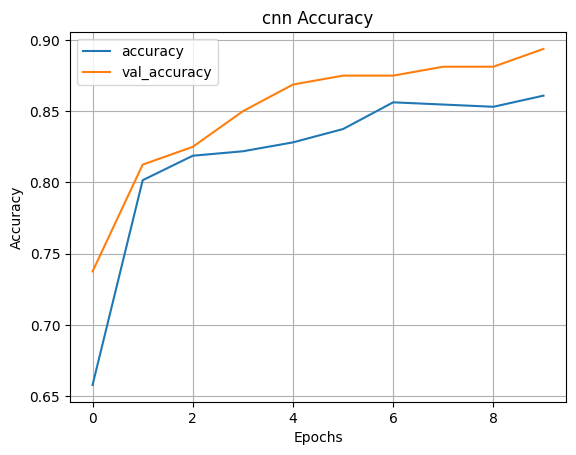

Classification report for cnn:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        82
           1       0.92      0.86      0.89        78

    accuracy                           0.89       160
   macro avg       0.90      0.89      0.89       160
weighted avg       0.90      0.89      0.89       160



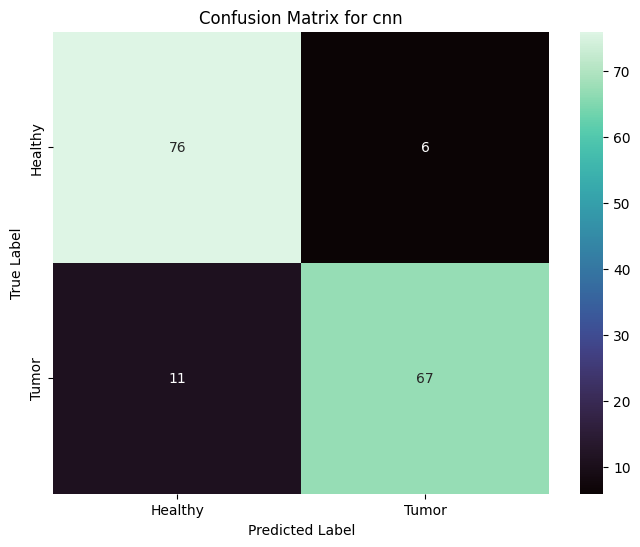

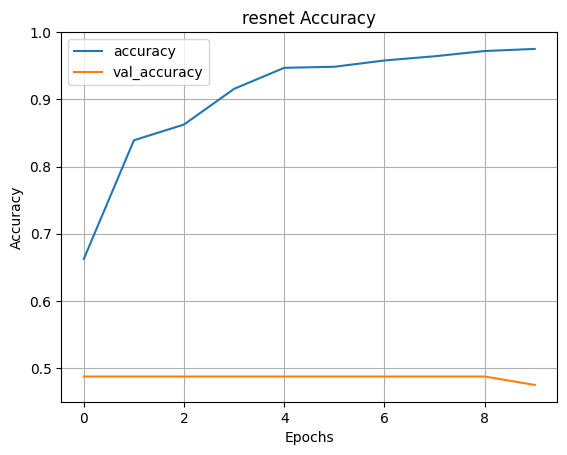

Classification report for resnet:
              precision    recall  f1-score   support

           0       0.45      0.12      0.19        82
           1       0.48      0.85      0.61        78

    accuracy                           0.48       160
   macro avg       0.47      0.48      0.40       160
weighted avg       0.47      0.47      0.40       160



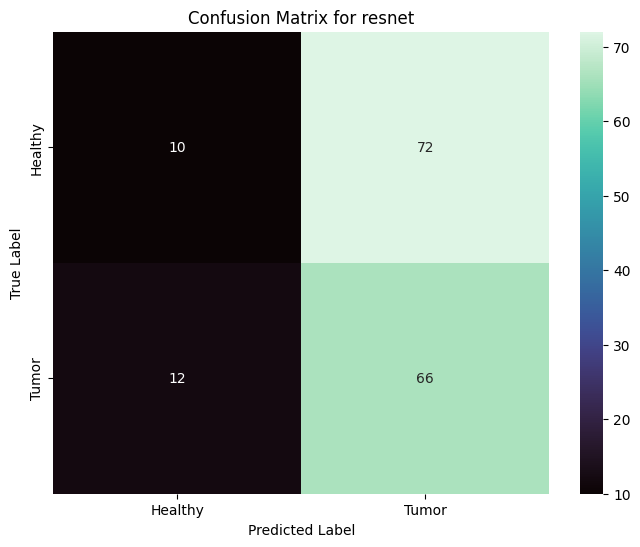

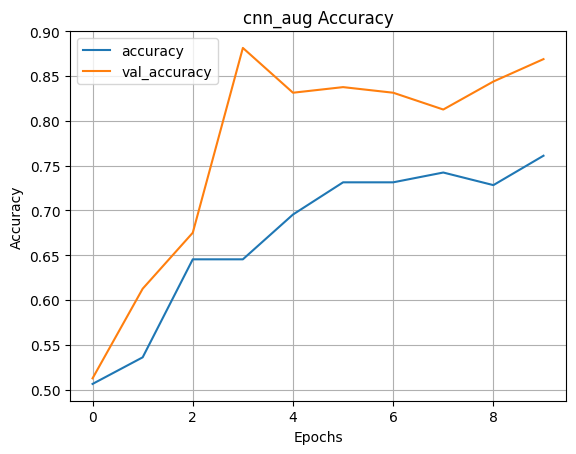

Classification report for cnn_aug:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88        82
           1       0.93      0.79      0.86        78

    accuracy                           0.87       160
   macro avg       0.88      0.87      0.87       160
weighted avg       0.88      0.87      0.87       160



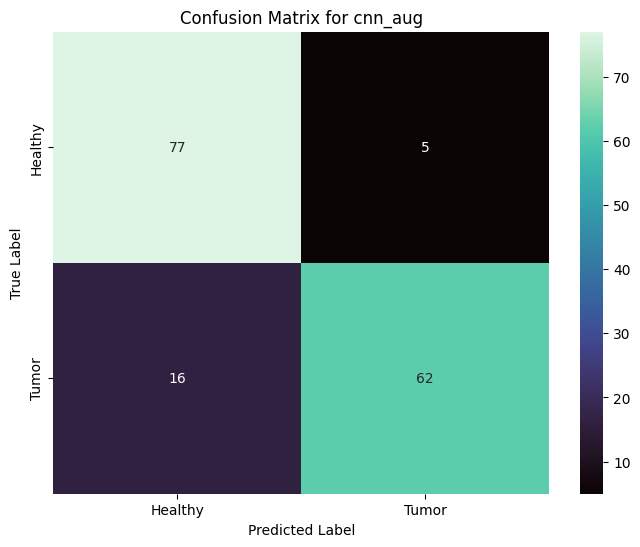

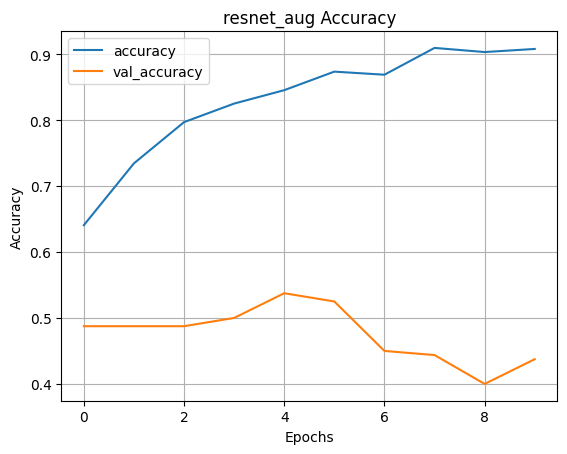

Classification report for resnet_aug:
              precision    recall  f1-score   support

           0       0.45      0.46      0.46        82
           1       0.42      0.41      0.42        78

    accuracy                           0.44       160
   macro avg       0.44      0.44      0.44       160
weighted avg       0.44      0.44      0.44       160



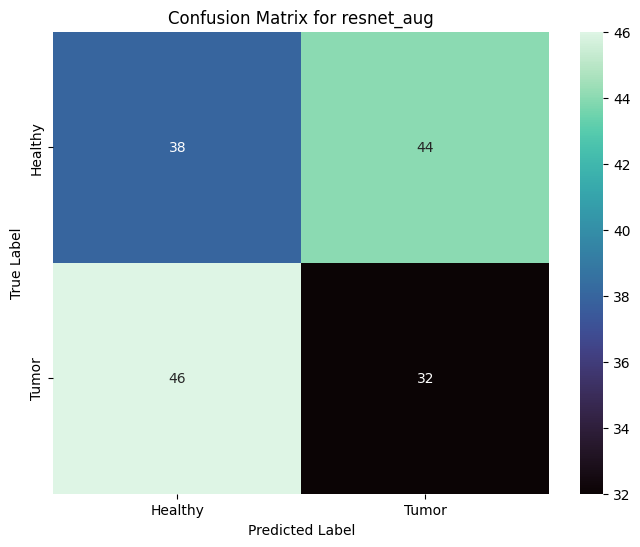

In [22]:
models=['cnn','resnet','cnn_aug','resnet_aug']
all_histories=[]
for i in models:
    all_histories.append(metrics[f'{i}_history'])

for i,name in enumerate(models):
    plt.figsize=(10,10)
    plt.plot(all_histories[i].history['accuracy'],label='accuracy')
    plt.plot(all_histories[i].history['val_accuracy'],label='val_accuracy')
    plt.title(f'{name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()
     # Print classification report
    print(f"Classification report for {name}:")
    print(classification_report(y_test,metrics[f'{name}_y_pred']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test,metrics[f'{name}_y_pred'])

    # Confusion Matrix Visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='mako', cbar=True,
                xticklabels=['Healthy', 'Tumor'], yticklabels=['Healthy', 'Tumor'])
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Aggregate Model Summary

In [23]:
metrics_summary=[]

for i,name in enumerate(models):

    final_train_accuracy=metrics[f'{name}_history'].history['accuracy'][-1]
    final_val_accuracy=metrics[f'{name}_history'].history['val_accuracy'][-1]
    final_train_loss=metrics[f'{name}_history'].history['loss'][-1]
    final_val_loss=metrics[f'{name}_history'].history['val_loss'][-1]
    metrics_summary.append({
            'Model': name,
            'Final Train Accuracy': final_train_accuracy,
            'Final Validation Accuracy': final_val_accuracy,
            'Final Train Loss': final_train_loss,
            'Final Validation Loss': final_val_loss
        })
metrics_df=pd.DataFrame(metrics_summary)
metrics_df

,Model,Final Train Accuracy,Final Validation Accuracy,Final Train Loss,Final Validation Loss
0,cnn,0.860937,0.89375,0.387461,0.358340
1,resnet,0.975000,0.47500,0.066338,1.364524
2,cnn_aug,0.760938,0.86875,0.579107,0.511142
3,resnet_aug,0.907812,0.43750,0.384906,0.904430


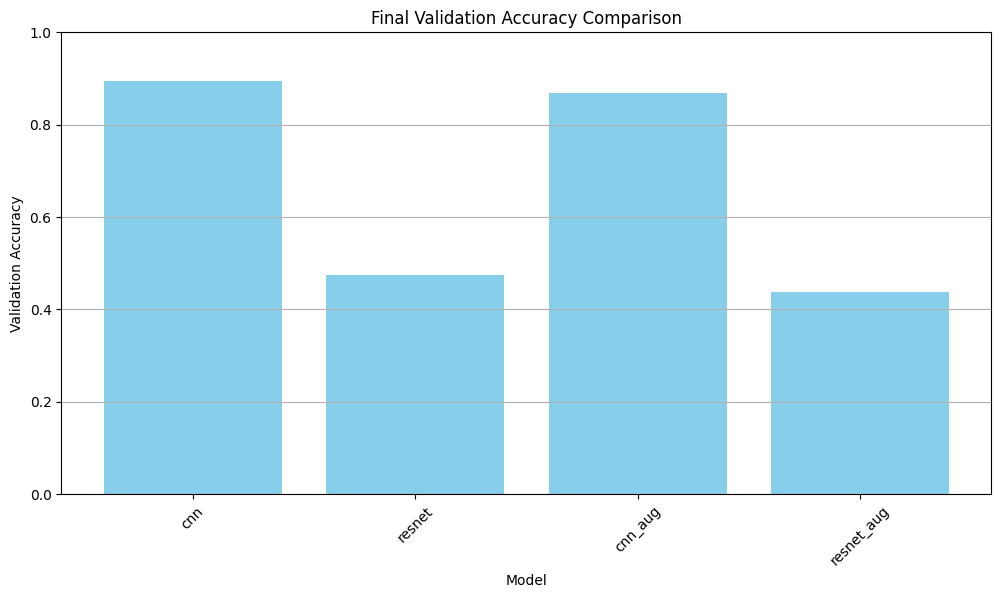

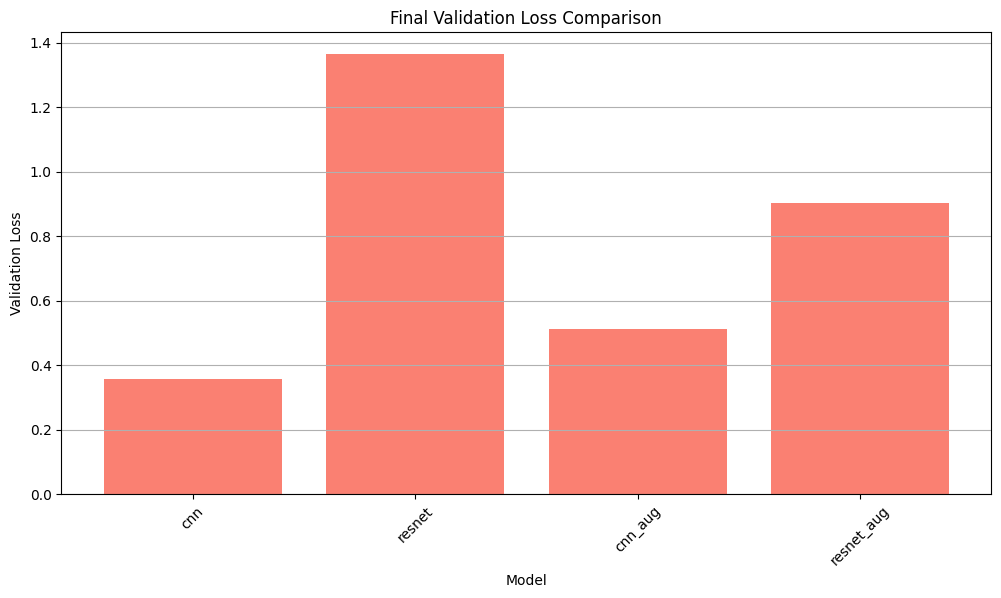

In [24]:
# Plotting Accuracy Comparison
plt.figure(figsize=(12, 6))
plt.bar(metrics_df['Model'], metrics_df['Final Validation Accuracy'], color='skyblue')
plt.title('Final Validation Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Validation Accuracy')
plt.xticks(rotation=45)
plt.ylim([0, 1])
plt.grid(axis='y')
plt.show()

# Plotting Loss Comparison
plt.figure(figsize=(12, 6))
plt.bar(metrics_df['Model'], metrics_df['Final Validation Loss'], color='salmon')
plt.title('Final Validation Loss Comparison')
plt.xlabel('Model')
plt.ylabel('Validation Loss')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

> Since After evaluating all the models CNN (without augmented data) performs the best, we will be using the same for the future predicitons for such cases as well.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


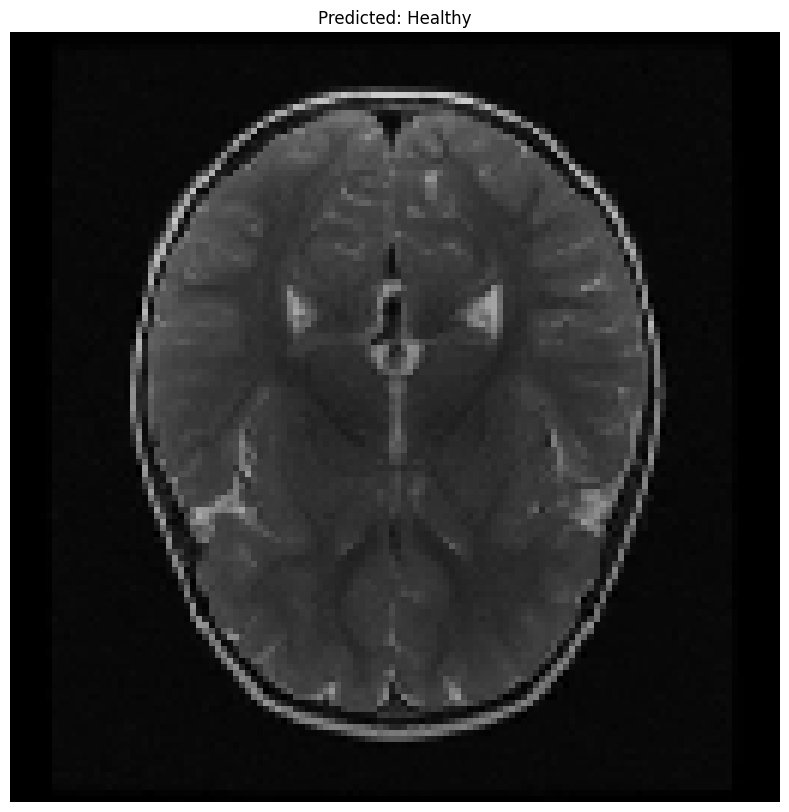

In [25]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Randomly select an index
rand = random.randint(0, len(X_test) - 1)

# Select a single input from X_test
input_image = X_test[rand]

# Add batch dimension to the input
input_image = np.expand_dims(input_image, axis=0)  # Shape becomes (1, 128, 128, 3)

# Predict using the model
y_pred = cnn_model.predict(input_image)

# Visualize the image with the prediction
plt.figure(figsize=(15, 10))
plt.imshow(X_test[rand])  # Original image
plt.title(f"Predicted: {'Healthy' if y_pred[0]<0.5 else 'Tumor'}")  # Display the prediction
plt.axis('off')
plt.show()
